# Image Classification with Cleanlab, PyTorch & Skorch

This tutorial will use Cleanlab to find potential label errors in the MNIST handwritten digit image dataset. This dataset contains 60,000 images of handwritten digits from 0 to 9. We'll find *more than a thousand* highly suspicious examples with label errors and edge cases by the end of this tutorial. 

**Overview of what we'll do in this tutorial:**

- Build a simple PyTorch neural net and wrap it with Skorch to make it scikit-learn compatible.

- Compute the cross-validated predicted probabilities, ``pyx``, sometimes known as the out-of-sample predicted probabilities.

- Generate a list of potential label errors with Cleanlab's ``get_noise_indices``.

- Build and train a more robust model than the vanilla model after adapting it with Cleanlab's ``LearningWithNoisyLabels``. 

**Data:** https://www.openml.org/d/554

## 1. Install the required dependencies

``%%capture`` is a magic function to hides the cell's output.

In [1]:
%%capture

%pip install cleanlab pandas matplotlib torch torchvision skorch

## 2. Fetch and scale the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784')

# Assign the data features and labels to variable X and y respectively 
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')


<div class="alert alert-info">

Bringing Your Own Data (BYOD)?

Assign your data's features to variable ``X`` and its labels to variable ``y`` instead.

</div>

In [3]:

# Scale the features which range from 0 to 255 (256 levels on the grayscale) 
X /= 255.0

# Then convert it to a numpy array
X = X.to_numpy()

## 3. Define a classification model

Here, we define a simple neural network with PyTorch.

In [4]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.hidden = nn.Linear(28*28, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, X):
        X = nn.functional.relu(self.hidden(X))
        X = self.dropout(X)
        X = nn.functional.softmax(self.output(X), dim=-1)
        return X

## 4. Wrap with Skorch for scikit-learn compatibility

As some of Cleanlab's feature requires scikit-learn compatibility, we will need to adapt the above PyTorch neural net accordingly. Skorch is a convenient package that helps with this, read more about it here: https://skorch.readthedocs.io

In [5]:
from skorch import NeuralNetClassifier

# Wrap the PyTorch neural net around Skorch's NeuralNetClassifier wrapper
net = NeuralNetClassifier(NeuralNetwork)

## 5. Compute the cross-validated predicted probabilities

If we'd like Cleanlab to identify potential label errors in the whole dataset and not just the training set, we can consider fitting the entire dataset. We will only use this model instance to compute the cross-validated predicted probabilities, ``pyx``, and not for model evaluation.

In [6]:
_ = net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7971       0.7896        1.1713  2.1920


      2        0.9768       0.8424        0.6943  2.1871


      3        0.7216       0.8656        0.5483  2.1833


      4        0.6146       0.8798        0.4774  2.1751


      5        0.5535       0.8849        0.4347  2.1801


      6        0.5131       0.8911        0.4053  2.1852


      7        0.4822       0.8961        0.3824  2.1935


      8        0.4592       0.9001        0.3652  2.1763


      9        0.4388       0.9037        0.3507  2.1776


     10        0.4233       0.9064        0.3381  2.1823


Compute the cross-validated predicted probabilities, ``pyx``, sometimes also known as the out-of-sample predicted probabilities.

In [7]:
from sklearn.model_selection import cross_val_predict

pyx = cross_val_predict(net, X, y, cv=3, method='predict_proba')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9766       0.7137        1.5747  1.1458


      2        1.2758       0.7878        0.9784  1.1978


      3        0.9116       0.8241        0.7381  1.1502


      4        0.7440       0.8453        0.6236  1.1493


      5        0.6584       0.8558        0.5570  1.1493


      6        0.5985       0.8655        0.5124  1.1560


      7        0.5540       0.8713        0.4804  1.1398


      8        0.5236       0.8765        0.4562  1.1603


      9        0.5041       0.8800        0.4369  1.1499


     10        0.4807       0.8814        0.4204  1.1384


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0062       0.7333        1.5904  1.1351


      2        1.2838       0.8097        0.9603  1.1347


      3        0.9065       0.8421        0.7128  1.1339


      4        0.7400       0.8568        0.5951  1.1359


      5        0.6493       0.8688        0.5264  1.1353


      6        0.5939       0.8789        0.4808  1.1343


      7        0.5484       0.8832        0.4489  1.1331


      8        0.5182       0.8880        0.4251  1.1331


      9        0.4927       0.8918        0.4051  1.1331


     10        0.4706       0.8939        0.3889  1.1337


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0486       0.7392        1.6689  1.1310


      2        1.3745       0.8070        1.0069  1.1318


      3        0.9658       0.8400        0.7345  1.1311


      4        0.7895       0.8594        0.6071  1.1446


      5        0.6929       0.8722        0.5351  1.1462


      6        0.6275       0.8802        0.4860  1.1467


      7        0.5823       0.8878        0.4518  1.1448


      8        0.5517       0.8917        0.4261  1.1457


      9        0.5252       0.8944        0.4052  1.1468


     10        0.5009       0.8978        0.3883  1.1475


## 6. Run Cleanlab to find potential label errors

Cleanlab has a ``get_noise_indices`` function to generate a list of potential label errors. Setting ``sorted_index_method="prob_given_label"`` returns the indices of all the most likely label errors, sorted by the most suspicious example first.

In [8]:
from cleanlab.pruning import get_noise_indices

ordered_label_errors = get_noise_indices(
    s=y,
    psx=pyx,
    sorted_index_method="prob_given_label"
)

## 7. Review some of the most likely mislabeled examples

In [9]:
print(f"Cleanlab found {len(ordered_label_errors)} potential label errors. Here are the indices of the top 15 most likely ones: \n {ordered_label_errors[:15]}")

Cleanlab found 1217 potential label errors. Here are the indices of the top 15 most likely ones: 
 [24798 18598  8729 61790 20820 31134  1352 59915 15942 66091 13031 53216
 55739 12679 50239]


We'll define a new ``plot_examples`` function to display any examples in a subplot conveniently.

In [10]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count+1)
        plt.imshow(X[id].reshape(28, 28))
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis('off')

    plt.tight_layout(h_pad=2.0)

Let's start by having an overview of the top 15 most likely label errors. From here, we can see a few label errors and edge cases. Feel free to change the parameters to display more or fewer examples. 

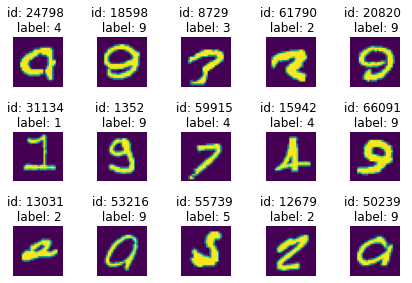

In [11]:
plot_examples(ordered_label_errors[range(15)], 3, 5)

Let's zoom into specific examples:

Given label is **4** but looks more like a **7**

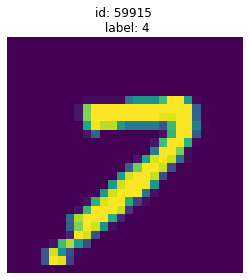

In [12]:
plot_examples([59915])

Given label is **4** but also looks like **9**

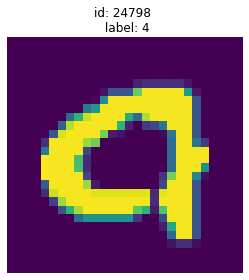

In [13]:
plot_examples([24798])

Edge case of odd looking **9**s

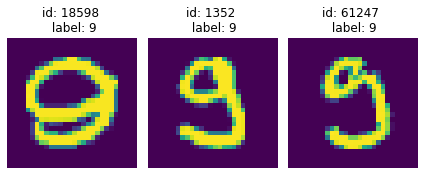

In [14]:
plot_examples([18598, 1352, 61247], 1, 3)

Cleanlab has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix label errors, augment edge cases or remove obscure examples. 

These human-in-the-loop processes may be time-consuming, so if you'd like Cleanlab to automatically remove these noisy examples and train a model directly on the partially mislabeled dataset, you're in luck! Cleanlab provides a ``LearningWithNoisyLabels`` wrapper to do precisely this:

## 8. Adapt with Cleanlab's wrapper and train a more robust model

First, we split the dataset into train and test subsets.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Re-instantiate a new scikit-learn compatible model with Skorch then wrap it with Cleanlab's ``LearningWithNoisyLabels`` wrapper.

In [16]:
from cleanlab.classification import LearningWithNoisyLabels

net = NeuralNetClassifier(NeuralNetwork)
clf = LearningWithNoisyLabels(clf=net)

In [17]:
_ = clf.fit(X_train, y_train.to_numpy())

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9991       0.7406        1.5933  1.1023


      2        1.3147       0.8235        0.9770  1.1051


      3        0.9377       0.8480        0.7246  1.1028


      4        0.7687       0.8625        0.6060  1.1063


      5        0.6781       0.8722        0.5370  1.1061


      6        0.6151       0.8794        0.4913  1.1095


      7        0.5720       0.8853        0.4587  1.1050


      8        0.5448       0.8892        0.4349  1.1035


      9        0.5156       0.8926        0.4153  1.1066


     10        0.4954       0.8965        0.3995  1.1051


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0071       0.7383        1.6077  1.1007


      2        1.3247       0.8098        0.9876  1.1013


      3        0.9443       0.8422        0.7315  1.1040


      4        0.7728       0.8581        0.6101  1.1013


      5        0.6802       0.8670        0.5409  1.1030


      6        0.6218       0.8751        0.4948  1.1145


      7        0.5770       0.8779        0.4617  1.1100


      8        0.5430       0.8836        0.4371  1.1011


      9        0.5191       0.8866        0.4175  1.1018


     10        0.4960       0.8895        0.4008  1.1039


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0009       0.7310        1.5891  1.1019


      2        1.3027       0.8148        0.9623  1.1033


      3        0.9243       0.8452        0.7130  1.1028


      4        0.7588       0.8619        0.5965  1.1013


      5        0.6682       0.8699        0.5307  1.1043


      6        0.6087       0.8776        0.4861  1.1050


      7        0.5662       0.8819        0.4544  1.1049


      8        0.5338       0.8864        0.4303  1.1043


      9        0.5082       0.8902        0.4114  1.1211


     10        0.4886       0.8921        0.3961  1.1021


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9904       0.7547        1.5808  1.1035


      2        1.2986       0.8208        0.9578  1.1171


      3        0.9210       0.8477        0.7063  1.1041


      4        0.7539       0.8635        0.5881  1.1294


      5        0.6684       0.8724        0.5220  1.1031


      6        0.6071       0.8788        0.4785  1.1078


      7        0.5650       0.8855        0.4467  1.1022


      8        0.5363       0.8879        0.4232  1.1029


      9        0.5072       0.8930        0.4036  1.1027


     10        0.4889       0.8953        0.3886  1.1041


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9984       0.7360        1.5876  1.1026


      2        1.3015       0.8131        0.9677  1.1021


      3        0.9231       0.8441        0.7179  1.1031


      4        0.7628       0.8578        0.5995  1.1015


      5        0.6663       0.8708        0.5298  1.1041


      6        0.6118       0.8791        0.4851  1.1027


      7        0.5666       0.8855        0.4526  1.1043


      8        0.5301       0.8898        0.4271  1.1031


      9        0.5081       0.8936        0.4080  1.1032


     10        0.4876       0.8956        0.3930  1.1033


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9108       0.7495        1.3893  1.3564


      2        1.1223       0.8480        0.7911  1.3546


      3        0.7865       0.8724        0.5804  1.3635


      4        0.6406       0.8866        0.4807  1.3543


      5        0.5591       0.8957        0.4205  1.3574


      6        0.5090       0.9012        0.3808  1.3592


      7        0.4671       0.9060        0.3523  1.3649


      8        0.4406       0.9101        0.3305  1.3549


      9        0.4170       0.9121        0.3137  1.4031


     10        0.3967       0.9150        0.2992  1.3719


## 9. Evaluate the robust model's performance

In [18]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9011428571428571

## What's next?

Congratulations on completing this tutorial! Check out our following tutorial on using Cleanlab for text classification, where we found ``hundreds`` of potential label errors in one of the most well-known text datasets, the IMBDb movie review dataset!